#                     Fundamentals of Machine Learning - 2022
#                     Report 2 - Classifying with convnets - Transfer Learning
###                          Facundo Sheffield

In this notebook we will try to use transfer learning to get better results in our image predictions. In particular, we plan on using the VGG16 network trained on ImageNet and see how far that takes us.

 Since this was done on Google Colab, lets start by mounting our drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we import the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow

And proceed to load the data. Note that since we plan on using VGG16 we have to add 3 channels to the images, because the network was trained to classify RGB images.

In [3]:
# Lets convert our images to RGB:
with open('/content/drive/My Drive/faces_dict.p', 'rb') as f:
    faces_dict = pickle.load(f)
images = faces_dict['images']
images = np.stack((images,)*3, axis=-1)

# now lets add color to our images:
#images[1,:,:,2]=1
#images[1,:,:,2]=0.2


faces_dict.update({'images': np.array(images)})
print(faces_dict['images'].shape)

(400, 64, 64, 3)


Next, we split our data:

In [5]:
# Lets start by separating into train, test and validation:

from sklearn.model_selection import train_test_split
Full_X_train, X_test, Full_y_train, y_test = train_test_split(faces_dict['images'], faces_dict['target'], test_size=100, random_state=42, stratify=faces_dict['target'])
X_train, X_val, y_train, y_val = train_test_split(Full_X_train, Full_y_train, test_size=80, random_state=42, stratify=Full_y_train)

print(f"Training, validation and test data: {len(X_train)}, {len(X_val)}, {len(X_test)}")

Training, validation and test data: 220, 80, 100


We will use the same type of augmentation we used for our original CNN.

In [6]:
# Lets augment the data:
import random
def add_noise(img):
    '''Adds random noise to an image'''
    VARIABILITY = 0.1
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 1.)
    return img

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,  # Mx angle for random rotations
    width_shift_range=0.1, # Max horizontal shift
    height_shift_range=0.1, # Max vertical shift
    shear_range=2, # Shear degree
    horizontal_flip=True,  # Mirror
    zoom_range = 0.03, # Zoom
    preprocessing_function=add_noise, # Adds noise
    fill_mode='nearest')

datagen.fit(X_train, augment=True, seed=42)
it = datagen.flow(X_train, y_train, batch_size=32)  # iterator, each instance returns a tuple (x, y) of batch_size images and corresponding labels

And now is when things get interesting. The whole point of transfer learning is to used a pretrained model when training data is limited. In this case we will be using VGG16, which can be imported from Keras.

In [7]:
# Lets do transfer learning with mobileNet:
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# create the base pre-trained model
#base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3)) # if include_top=True the image must be 224*224

# lets freeze the layers:
base_model.trainable = False
# Note: be careful with BatchNormalization layers

# Lets take a look at the architecture:
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

As seen above, our base model has over 14 million parameters, but these are frozen and do not change with each new epoch. 

Lets now add some layers to finish the model. In particular we add an average pooling and two dense layers. We will maintain an Adam optimizer, with cross entropy for loss and accuracy as our metric.

In [47]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(40, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Lets take a look at the transfer learning model:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

Now that we have our complete model based on VGG16, lets train it like we did with our CNN.

In [48]:
# Lets train the model:
history = model.fit(it, steps_per_epoch=len(X_train)/32, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
6/6 [==============================] - 1s 125ms/step - loss: 3.8519 - accuracy: 0.0273 - val_loss: 3.5358 - val_accuracy: 0.1250
Epoch 2/500
6/6 [==============================] - 1s 79ms/step - loss: 3.5352 - accuracy: 0.0955 - val_loss: 3.3857 - val_accuracy: 0.1625
Epoch 3/500
6/6 [==============================] - 1s 78ms/step - loss: 3.3417 - accuracy: 0.1091 - val_loss: 3.2104 - val_accuracy: 0.2000
Epoch 4/500
6/6 [==============================] - 1s 79ms/step - loss: 3.1016 - accuracy: 0.2682 - val_loss: 3.0472 - val_accuracy: 0.3000
Epoch 5/500
6/6 [==============================] - 1s 75ms/step - loss: 2.9428 - accuracy: 0.2591 - val_loss: 2.8927 - val_accuracy: 0.2750
Epoch 6/500
6/6 [==============================] - 1s 75ms/step - loss: 2.7408 - accuracy: 0.3409 - val_loss: 2.7561 - val_accuracy: 0.3500
Epoch 7/500
6/6 [==============================] - 1s 74ms/step - loss: 2.5894 - accuracy: 0.3773 - val_loss: 2.6158 - val_accuracy: 0.3375
Epoch 8/500
6/6 [==

Lets plot the results of this model. It is interesting to see that, unlike our previous CNN, here the validation accuracy and loss have worse results than the training ones.

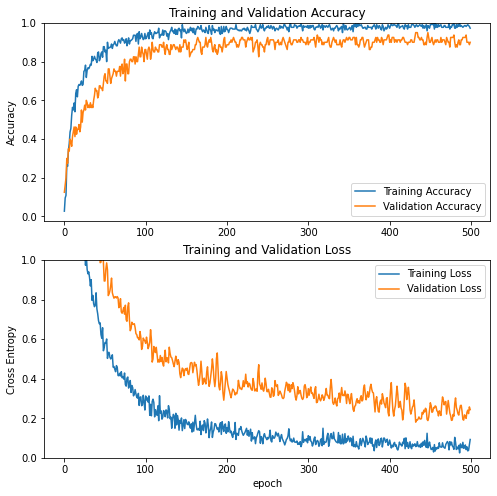

In [50]:
# Lets plot our results
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We see that for 500 epochs we have a relatively low validation accuracy at 0.9. There are several possible explanations for this. For example, VGG16 was trained with coloured, 224*224 images; and here we have faces in grayscale and with lower quality. Apart from that, we are using less that half of the number of free parameters we used for our CNN.


Personally I believe the problem relies on the fact that VGG deals much better with coloured images. In order to solve this problem there are various approaches:


1) Use a trained ML model to colour our dataset. (Note that this will mean that we will have to run our test data through said model)


2) Re-train the VGG16 Network using grayscale images (the imageNet data can be found on grayscale).  


3) Mapping the grayscale input to RGB with trainable convolutional layer.


In the case of the first option I had trouble with library dependencies and could not pull it off. 


The second option, while feasible, would require too much computational time.

Thus, we are left with the final option of mapping the grayscale to RGB. Lets see how that performs.

In [11]:
# We reload our data to reshape it accordingly, and then do the same split

with open('/content/drive/My Drive/faces_dict.p', 'rb') as f:
    faces_dict = pickle.load(f)
new_val = []
for image in faces_dict['images']:

    new_val.append(np.expand_dims(image, axis=2))

faces_dict.update({'images': np.array(new_val)})


Full_X_train, X_test, Full_y_train, y_test = train_test_split(faces_dict['images'], faces_dict['target'], test_size=100, random_state=42, stratify=faces_dict['target'])
X_train, X_val, y_train, y_val = train_test_split(Full_X_train, Full_y_train, test_size=80, random_state=42, stratify=Full_y_train)

print(f"Training, validation and test data: {len(X_train)}, {len(X_val)}, {len(X_test)}")

Training, validation and test data: 220, 80, 100


In [12]:
from keras import Input, layers

input_tensor = Input(shape=(64, 64, 1))
y = layers.Conv2D(3, (3, 3), padding='same')(input_tensor)

x = base_model(y)  # VGG16

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)

# add a fully-connected layer
x = Dense(1024, activation='relu')(x)  # could try to change this
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(40, activation='softmax')(x)

# this is the model we will train
model_2 = Model(inputs=input_tensor, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Lets take a look at the transfer learning model:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         30        
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                           

In [13]:
history = model_2.fit(it, steps_per_epoch=len(X_train)/32, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
6/6 [==============================] - 1s 89ms/step - loss: 4.0685 - accuracy: 0.0182 - val_loss: 3.6511 - val_accuracy: 0.0875
Epoch 2/500
6/6 [==============================] - 0s 51ms/step - loss: 3.7776 - accuracy: 0.0591 - val_loss: 3.5245 - val_accuracy: 0.0625
Epoch 3/500
6/6 [==============================] - 0s 48ms/step - loss: 3.6651 - accuracy: 0.0636 - val_loss: 3.4209 - val_accuracy: 0.1000
Epoch 4/500
6/6 [==============================] - 0s 48ms/step - loss: 3.5917 - accuracy: 0.0545 - val_loss: 3.2956 - val_accuracy: 0.3500
Epoch 5/500
6/6 [==============================] - 0s 50ms/step - loss: 3.4313 - accuracy: 0.0955 - val_loss: 3.1905 - val_accuracy: 0.3375
Epoch 6/500
6/6 [==============================] - 0s 48ms/step - loss: 3.3784 - accuracy: 0.1545 - val_loss: 3.0534 - val_accuracy: 0.3375
Epoch 7/500
6/6 [==============================] - 0s 49ms/step - loss: 3.1963 - accuracy: 0.2045 - val_loss: 2.9080 - val_accuracy: 0.3375
Epoch 8/500
6/6 [===

We can see that know we get much better results regarding the validation accuracy. Lets take a look at the plots:

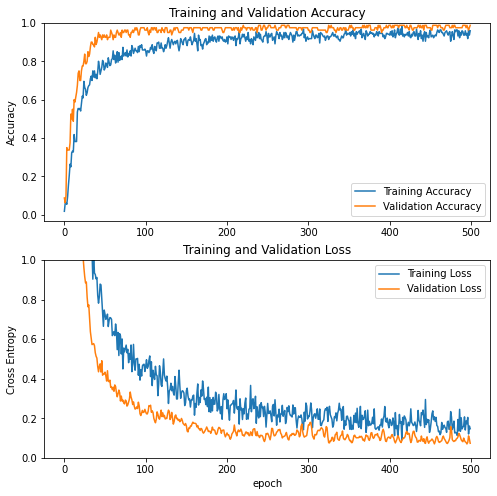

In [16]:
# Lets plot our results
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see that after 200 epochs the validation accuracy seems to remain almost constant, while the training one increases. This could be a sign of overfitting. 

Still, based on the validation score, model_2 seems to be performing better, so we will use that as our final TL model.

Lets fit model_2 with the validation data and then save it:

In [17]:
datagen = ImageDataGenerator(
    rotation_range=10,  # Mx angle for random rotations
    width_shift_range=0.1, # Max horizontal shift
    height_shift_range=0.1, # Max vertical shift
    shear_range=2, # Shear degree
    horizontal_flip=True,  # Mirror
    zoom_range = 0.02, # Zoom
    preprocessing_function=add_noise, # Adds noise
    fill_mode='nearest')

datagen.fit(Full_X_train, augment=True, seed=42)
it = datagen.flow(Full_X_train, Full_y_train, batch_size=32)

In [18]:
input_tensor = Input(shape=(64, 64, 1))
y = layers.Conv2D(3, (3, 3), padding='same')(input_tensor)

x = base_model(y)

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)

# add a fully-connected layer
x = Dense(1024, activation='relu')(x)  # could try to change this
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(40, activation='softmax')(x)

# this is the model we will train
model_two = Model(inputs=input_tensor, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model_two.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In this case we have not increased the number of epochs to 700 like we did with the CNN to avoid potential overfitting of the data.

In [19]:
history_two = model_two.fit(it, steps_per_epoch=len(X_train)/32, epochs=500)

Epoch 1/500
6/6 [==============================] - 1s 45ms/step - loss: 3.9764 - accuracy: 0.0268
Epoch 2/500
6/6 [==============================] - 1s 153ms/step - loss: 3.7659 - accuracy: 0.0196
Epoch 3/500
6/6 [==============================] - 0s 38ms/step - loss: 3.6084 - accuracy: 0.0735
Epoch 4/500
6/6 [==============================] - 0s 37ms/step - loss: 3.4731 - accuracy: 0.0882
Epoch 5/500
6/6 [==============================] - 0s 36ms/step - loss: 3.2767 - accuracy: 0.1569
Epoch 6/500
6/6 [==============================] - 0s 38ms/step - loss: 3.2226 - accuracy: 0.1373
Epoch 7/500
6/6 [==============================] - 0s 38ms/step - loss: 3.0578 - accuracy: 0.1716
Epoch 8/500
6/6 [==============================] - 0s 40ms/step - loss: 2.9438 - accuracy: 0.2411
Epoch 9/500
6/6 [==============================] - 0s 39ms/step - loss: 2.8709 - accuracy: 0.2647
Epoch 10/500
6/6 [==============================] - 0s 36ms/step - loss: 2.6939 - accuracy: 0.2843
Epoch 11/500
6/6 [

Lets plot the results, mostly for completeness:

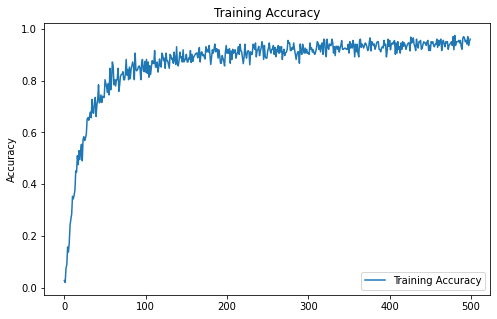

In [21]:
# lets plot the results:
acc = history_two.history['accuracy']
loss = history_two.history['loss']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

plt.title('Training Accuracy')
plt.show()


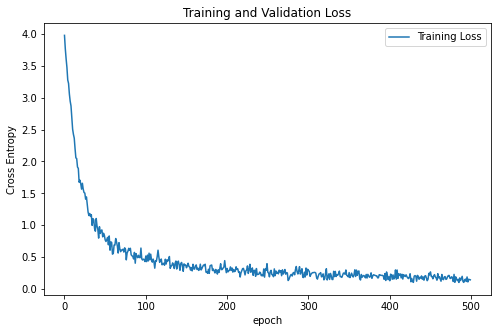

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

And finally, lets export this model

In [23]:
# Lets export the model:
model_two.save('TransferLearning_model.h5')